In [16]:
import pickle
from config_and_print import methy_directory, filtered_list, chrom_file, resolutions, output_directory, mappability_threshold, normalization, iterations
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import os
import matplotlib.colors as mcolors
import textwrap

# Ensure resolutions is treated as a tuple or list of strings
if isinstance(resolutions, str):
    resolutions = (resolutions,)

# Print resolutions for debugging 
print(f"Resolutions from config: {resolutions}")

# Extract resolution value and label from the resolutions string
resolution_str = resolutions[0]

# Debug print to check the value of resolution_str
print(f"Extracted resolution string: {resolution_str}")

def parse_resolution(resolution_str):
    if ':' in resolution_str:
        resolution_value, resolution_label = resolution_str.split(':')
        try:
            resolution = int(resolution_value)
            return resolution, resolution_label
        except ValueError:
            raise ValueError(f"Resolution value should be an integer: '{resolution_value}' in '{resolution_str}'")
    else:
        raise ValueError(f"Invalid resolution format: '{resolution_str}'. Expected format 'value:label', e.g., '1000000:1Mb'.")

resolution, resolution_label = parse_resolution(resolution_str)

# Load original_bulk_data from the file
bulk_data_input_file = f'../../projects/single_cell_files/nan_removed_bulk_data_res{resolution}.pkl'
with open(bulk_data_input_file, 'rb') as f:
    bulk_data = pickle.load(f)
print(f"bulk_data loaded from {bulk_data_input_file}")

# Load original_bulk_data from the file
original_bulk_data_input_file = f'../../projects/single_cell_files/original_bulk_data_res{resolution}.pkl'
with open(original_bulk_data_input_file, 'rb') as f:
    original_bulk_data = pickle.load(f)
print(f"original_bulk_data loaded from {bulk_data_input_file}")


#load the dark regions data and the A/B compartment data
loaded_data = np.load('/home/dwk681/workspace/cluster_cells_from_GSE189158_NOMe_HiC/bins_to_remove.npz')

# Convert the loaded data back into a dictionary with the same structure
bins_to_remove = {chrom: loaded_data[chrom] for chrom in loaded_data}

############################################
# imports
############################################

import pyBigWig
import scipy.io as sio
import numpy as np
import math 
import matplotlib.pyplot as plt
import os
import pandas as pd
from heapq import nlargest
import copy
import matplotlib.gridspec as gridspec
import pandas as pd
import pickle
import seaborn as sns
import h5py
from scipy.stats import pearsonr
from config_and_print import methy_directory, filtered_list, chrom_file, resolutions, output_directory, mappability_threshold, normalization
#chromosomes = [f'chr{chrom}' for chrom in chromosomes]

# Ensure resolutions is treated as a tuple or list of strings
if isinstance(resolutions, str):
    resolutions = (resolutions,)

# Print resolutions for debugging
print(f"Resolutions from config: {resolutions}")

# Extract resolution value and label from the resolutions string
resolution_str = resolutions[0]

# Debug print to check the value of resolution_str
print(f"Extracted resolution string: {resolution_str}")

def parse_resolution(resolution_str):
    if ':' in resolution_str:
        resolution_value, resolution_label = resolution_str.split(':')
        try:
            resolution = int(resolution_value)
            return resolution, resolution_label
        except ValueError:
            raise ValueError(f"Resolution value should be an integer: '{resolution_value}' in '{resolution_str}'")
    else:
        raise ValueError(f"Invalid resolution format: '{resolution_str}'. Expected format 'value:label', e.g., '1000000:1Mb'.")

resolution, resolution_label = parse_resolution(resolution_str)

########################################################################
# create the cell type dictionary
# [TO DO] This needs to be replaced with SNPS code 
########################################################################
# Define the path file with prefixes and colors in the following form
#1       sc1.ACTTGA      red
#2       sc1.GCCAAT      red
#3       sc1.TAGCTT      red
#4       sc10.TAGCTT     blue
#
filename = '../../bin/name.order.HCG_methy.with_color.txt'

# Initialize an empty dictionary to store cell ID and color
cell_color_dict = {}

# Open and read the file
with open(filename, 'r') as file:
    for line in file:
        # Split the line into parts
        parts = line.strip().split()
        # Extract cell ID and color
        cell_id = parts[1]
        color = parts[2]
        # Store in dictionary
        cell_color_dict[cell_id] = color

# Define the path to the tensor sample order file
#This file contains the prefixes in the form
#sc11.ACTTGA
#sc11.CGATGT
#sc11.GCCAAT
#
tensor_order_filename = f'{output_directory}/filtered_bam_list.txt'

# Initialize a list to store the 1s and 0s
color_vector = []

# Open and read the tensor sample order file
with open(tensor_order_filename, 'r') as file:
    for line in file:
        sample_id = line.strip()  # Remove any trailing newlines or spaces
        if sample_id in cell_color_dict and cell_color_dict[sample_id] == 'red':
            color_vector.append(1)
        else:
            color_vector.append(0)

# Output the color vector to check
print(len(color_vector))

# Create a mapping dictionary
color_mapping = {
    'red': 'imr90',
    'blue': 'gm12878'
}

# Update the dictionary using the mapping
updated_cell_color_dict = {key: color_mapping[value] for key, value in cell_color_dict.items()}


path_to_sc_AB = "/home/dwk681/workspace/cluster_cells_from_GSE189158_NOMe_HiC/new_processing3/hicluster_1Mb_impute_dir"
correlated_GM12878 = {f'chr{i}': [] for i in range(1, 23)}

# Initialize a dictionary to store DataFrames for each chromosome
sc_dataframes_dict = {f'chr{i}': [] for i in range(1, 23)}

# Extract the sample IDs from the tensor_order_filename
sample_ids = []
with open(tensor_order_filename, 'r') as file:
    for line in file:
        sample_id = line.strip()
        sample_ids.append(sample_id)

for i in range(1, 23):
    chromosome = f'chr{i}'
    correlations_gm12878 = []

    key_gm12878 = f'res{resolution}_ch{i}_oe_GM12878_NONE_eigenvector'
    bulk_eigenvector_gm12878 = original_bulk_data[key_gm12878]['eigenvalue']

    for sample_id in sample_ids:
        file_name = f"{sample_id}_{chromosome}_pad1_std1_rp0.5_sqrtvc.cpgcomp.npy"
        file_path = os.path.join(path_to_sc_AB, chromosome, file_name)
        
        # Load single-cell eigenvector data
        sc_eigenvector = np.load(file_path)
        sc_eigenvector_trimmed = sc_eigenvector[:-3]
        
        # Create DataFrame for single-cell eigenvector
        df_sc = pd.DataFrame(sc_eigenvector_trimmed, columns=['sc_eigenvector'])
        
        # Create DataFrame for bulk eigenvector
        df_bulk = bulk_eigenvector_gm12878.to_frame(name='bulk_eigenvector')

        # Combine and filter the dataframes
        combined_df = pd.concat([df_bulk, df_sc], axis=1)
        indices_to_remove = bins_to_remove[chromosome]
        indices_to_keep = ~combined_df.index.isin(indices_to_remove)
        combined_df_filtered = combined_df[indices_to_keep].dropna()

        # Calculate the correlation
        corr = combined_df_filtered['bulk_eigenvector'].corr(combined_df_filtered['sc_eigenvector'])
        correlations_gm12878.append((sample_id, corr, df_sc.drop(indices_to_remove).reset_index(drop=True)))

    # Sort by correlation and store the DataFrames
    correlated_GM12878[chromosome] = sorted(correlations_gm12878, key=lambda x: x[1], reverse=True)
    
    # Extract and transpose the DataFrames for the current chromosome
    sc_dataframes_transposed = [df.T for _, _, df in correlated_GM12878[chromosome]]
    
    # Create a DataFrame for the current chromosome and store it in the dictionary
    sc_dataframe = pd.concat(sc_dataframes_transposed, axis=0).reset_index(drop=True)
    sc_dataframe.columns = [f'Bin_{index+1}' for index in range(len(sc_dataframe.columns))]
    
    # Assign the sample IDs as the index
    sc_dataframe.index = sample_ids
    
    # Store the DataFrame in the dictionary
    sc_dataframes_dict[chromosome] = sc_dataframe

# Example: Accessing the DataFrame for chr10
chromosome = 'chr10'
sc_dataframe_chr10 = sc_dataframes_dict[chromosome]

# To access all DataFrames:
for chromosome, df in sc_dataframes_dict.items():
    print(f"Chromosome: {chromosome}")
    print(df.head())










########################################################################
#compute the genome-wide correlation of the two AB compartment cell types
# should be somehting like .6 if all the above steps were done correctly
# this is a sanity check
# There seems to be a problem here
# I beleive the issue is that without KR normalization, 
# the genome wide correlation of bulk is not that high
########################################################################
# Initialize lists to collect the eigenvector values for IMR90 and GM12878
imr90_values = []
gm12878_values = []

# Loop through each chromosome
for i in range(1, 23):
    key_gm12878 = f'res{resolution}_ch{i}_oe_GM12878_{normalization}_eigenvector'
    key_imr90 = f'res{resolution}_ch{i}_oe_IMR90_{normalization}_eigenvector'                                                               
                                                               
    # Check if the keys exist in the data to avoid KeyErrors
    if key_gm12878 in bulk_data and key_imr90 in bulk_data:
        # Extend the list with the eigenvector values from each chromosome
        # Ensure values are numeric (floats or ints)
        gm12878_vals = bulk_data[key_gm12878]['eigenvalue']
        imr90_vals = bulk_data[key_imr90]['eigenvalue']
        imr90_values.extend(imr90_vals)
        gm12878_values.extend(gm12878_vals)
        
# Convert lists to pandas Series for correlation calculation
imr90_series = pd.Series(imr90_values)
gm12878_series = pd.Series(gm12878_values)

# Calculate the Pearson correlation coefficient between IMR90 and GM12878
genome_wide_correlation = imr90_series.corr(gm12878_series)

print(f'Genome-wide correlation between IMR90 and GM12878: {genome_wide_correlation}')


Resolutions from config: ('1000000:1Mb',)
Extracted resolution string: 1000000:1Mb
bulk_data loaded from ../../projects/single_cell_files/nan_removed_bulk_data_res1000000.pkl
original_bulk_data loaded from ../../projects/single_cell_files/nan_removed_bulk_data_res1000000.pkl
Resolutions from config: ('1000000:1Mb',)
Extracted resolution string: 1000000:1Mb
129
Chromosome: chr1
                Bin_1     Bin_2     Bin_3     Bin_4     Bin_5     Bin_6  \
sc11.ACTTGA  0.010521  0.011070  0.012561  0.011688  0.009903  0.010413   
sc11.CGATGT  0.014757  0.014551  0.015608  0.014301  0.012289  0.012845   
sc11.GCCAAT  0.014781  0.013777  0.015257  0.015342  0.014960  0.013180   
sc11.TAGCTT  0.009246  0.011384  0.013013  0.012650  0.013231  0.015757   
sc12.ACTTGA  0.012379  0.013597  0.016424  0.018780  0.018926  0.015533   

                Bin_7     Bin_8     Bin_9    Bin_10  ...   Bin_219   Bin_220  \
sc11.ACTTGA  0.011515  0.012926  0.013061  0.014087  ...  0.008795  0.008316   
sc11.CGAT

In [18]:
sc_dataframes_dict['chr1']

,Bin_1,Bin_2,Bin_3,Bin_4,Bin_5,Bin_6,Bin_7,Bin_8,Bin_9,Bin_10,...,Bin_219,Bin_220,Bin_221,Bin_222,Bin_223,Bin_224,Bin_225,Bin_226,Bin_227,Bin_228
sc11.ACTTGA,0.010521,0.011070,0.012561,0.011688,0.009903,0.010413,0.011515,0.012926,0.013061,0.014087,...,0.008795,0.008316,0.007809,0.007905,0.008366,0.008770,0.009189,0.008734,0.008194,0.007412
sc11.CGATGT,0.014757,0.014551,0.015608,0.014301,0.012289,0.012845,0.012612,0.014443,0.015031,0.013625,...,0.006500,0.007619,0.010215,0.012031,0.011471,0.009964,0.010263,0.009456,0.009177,0.008794
sc11.GCCAAT,0.014781,0.013777,0.015257,0.015342,0.014960,0.013180,0.011402,0.012238,0.013595,0.013351,...,0.008366,0.009100,0.010513,0.011110,0.011237,0.010675,0.010173,0.009651,0.009005,0.007690
sc11.TAGCTT,0.009246,0.011384,0.013013,0.012650,0.013231,0.015757,0.015013,0.013637,0.013502,0.014278,...,0.007980,0.008857,0.009651,0.010884,0.011247,0.010649,0.010097,0.008884,0.008282,0.007166
sc12.ACTTGA,0.012379,0.013597,0.016424,0.018780,0.018926,0.015533,0.015263,0.016209,0.014839,0.012536,...,0.008182,0.009172,0.009257,0.009643,0.009728,0.009743,0.009334,0.008391,0.007567,0.007488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sc8.ACTTGA,0.008682,0.009455,0.010643,0.012412,0.014433,0.013389,0.010466,0.008137,0.010100,0.011232,...,0.010041,0.010899,0.009698,0.008747,0.009421,0.009425,0.010317,0.010422,0.010381,0.008034
sc9.ACTTGA,0.012788,0.011772,0.012258,0.014548,0.016037,0.012523,0.008166,0.009509,0.009843,0.008830,...,0.008644,0.011282,0.012371,0.011834,0.012072,0.012129,0.011811,0.010498,0.009708,0.007125
sc9.CGATGT,0.007085,0.011160,0.014235,0.015531,0.017673,0.019931,0.019757,0.017516,0.012737,0.011669,...,0.010212,0.012005,0.011147,0.010176,0.009843,0.010334,0.010557,0.011740,0.011989,0.010985
sc9.GCCAAT,0.008288,0.006680,0.009298,0.010178,0.009881,0.008661,0.011408,0.012808,0.012780,0.012582,...,0.009489,0.008992,0.008267,0.007680,0.008238,0.007073,0.006734,0.007267,0.007697,0.007132


In [39]:
# Initialize a list to store DataFrames for each chromosome
sc_dataframes_list = []

# Extract the sample IDs from the tensor_order_filename
sample_ids = []
with open(tensor_order_filename, 'r') as file:
    for line in file:
        sample_id = line.strip()
        sample_ids.append(sample_id)

for i in range(1, 23):
    chromosome = f'chr{i}'
    correlations_gm12878 = []

    key_gm12878 = f'res{resolution}_ch{i}_oe_GM12878_NONE_eigenvector'
    bulk_eigenvector_gm12878 = original_bulk_data[key_gm12878]['eigenvalue']

    # Initialize a list to store rows for the current chromosome's DataFrame
    chromosome_data = []

    for sample_id in sample_ids:
        file_name = f"{sample_id}_{chromosome}_pad1_std1_rp0.5_sqrtvc.cpgcomp.npy"
        file_path = os.path.join(path_to_sc_AB, chromosome, file_name)
        
        # Load single-cell eigenvector data
        sc_eigenvector = np.load(file_path)
        sc_eigenvector_trimmed = sc_eigenvector[:-3]
        
        # Create DataFrame for single-cell eigenvector
        df_sc = pd.DataFrame(sc_eigenvector_trimmed, columns=['sc_eigenvector'])
        
        # Create DataFrame for bulk eigenvector
        df_bulk = bulk_eigenvector_gm12878.to_frame(name='bulk_eigenvector')

        # Combine and filter the dataframes
        combined_df = pd.concat([df_bulk, df_sc], axis=1)
        indices_to_remove = bins_to_remove[chromosome]
        indices_to_keep = ~combined_df.index.isin(indices_to_remove)
        combined_df_filtered = combined_df[indices_to_keep].dropna()

        # Calculate the correlation
        corr = combined_df_filtered['bulk_eigenvector'].corr(combined_df_filtered['sc_eigenvector'])
        correlations_gm12878.append((sample_id, corr, df_sc.drop(indices_to_remove).reset_index(drop=True)))

        # Flatten the DataFrame into a single vector
        bin_values_vector = df_sc['sc_eigenvector'].tolist()
        
        # Get the label (IMR90 or GM12878) from the updated_cell_color_dict
        label = updated_cell_color_dict[sample_id]
        
        # Append the row as a tuple to the chromosome_data list
        chromosome_data.append((bin_values_vector, label))

    # Convert the chromosome_data list into a DataFrame for the current chromosome
    chromosome_dataframe = pd.DataFrame(chromosome_data, columns=['Bin_Values', 'Label'])
    
    # Sort the DataFrame so GM12878 are on top and IMR90 are on the bottom
    chromosome_dataframe_sorted = chromosome_dataframe.sort_values(by='Label', ascending=True).reset_index(drop=True)
    
    # Correctly identify the index where GM12878 ends (it should be 37, since index is 0-based)
    gm12878_end_idx = 38
    
    # Create a DataFrame with NaNs to insert
    nan_row = pd.DataFrame([[np.nan] * len(chromosome_dataframe_sorted.columns)], columns=chromosome_dataframe_sorted.columns)
    nan_rows = pd.concat([nan_row] * 5, ignore_index=True)  # Add 5 rows of NaNs
    
    # Insert the NaN rows between GM12878 and IMR90
    chromosome_dataframe_final = pd.concat([
        chromosome_dataframe_sorted.iloc[:gm12878_end_idx],
        nan_rows,
        chromosome_dataframe_sorted.iloc[gm12878_end_idx:]
    ]).reset_index(drop=True)
    
    # Add this DataFrame to the sc_dataframes_list
    sc_dataframes_list.append(chromosome_dataframe_final)



In [40]:
pd.set_option('display.max_rows', None)
sc_dataframes_list[11]

,Bin_Values,Label
0,"[0.012852227536507903, 0.013273793247676921, 0...",gm12878
1,"[0.016339597093952992, 0.014814225317169178, 0...",gm12878
2,"[0.009374324085371573, 0.009826398287166565, 0...",gm12878
3,"[0.015374157303370786, 0.013868, 0.01048142094...",gm12878
4,"[0.01009424168369899, 0.010191106500279115, 0....",gm12878
5,"[0.01217850550402646, 0.012536217738687395, 0....",gm12878
6,"[0.015374157303370786, 0.013868, 0.01417, 0.01...",gm12878
7,"[0.010978183329731758, 0.01135383896157372, 0....",gm12878
8,"[0.015374157303370786, 0.00729346846983892, 0....",gm12878
9,"[0.010689851651720842, 0.01179847267208085, 0....",gm12878


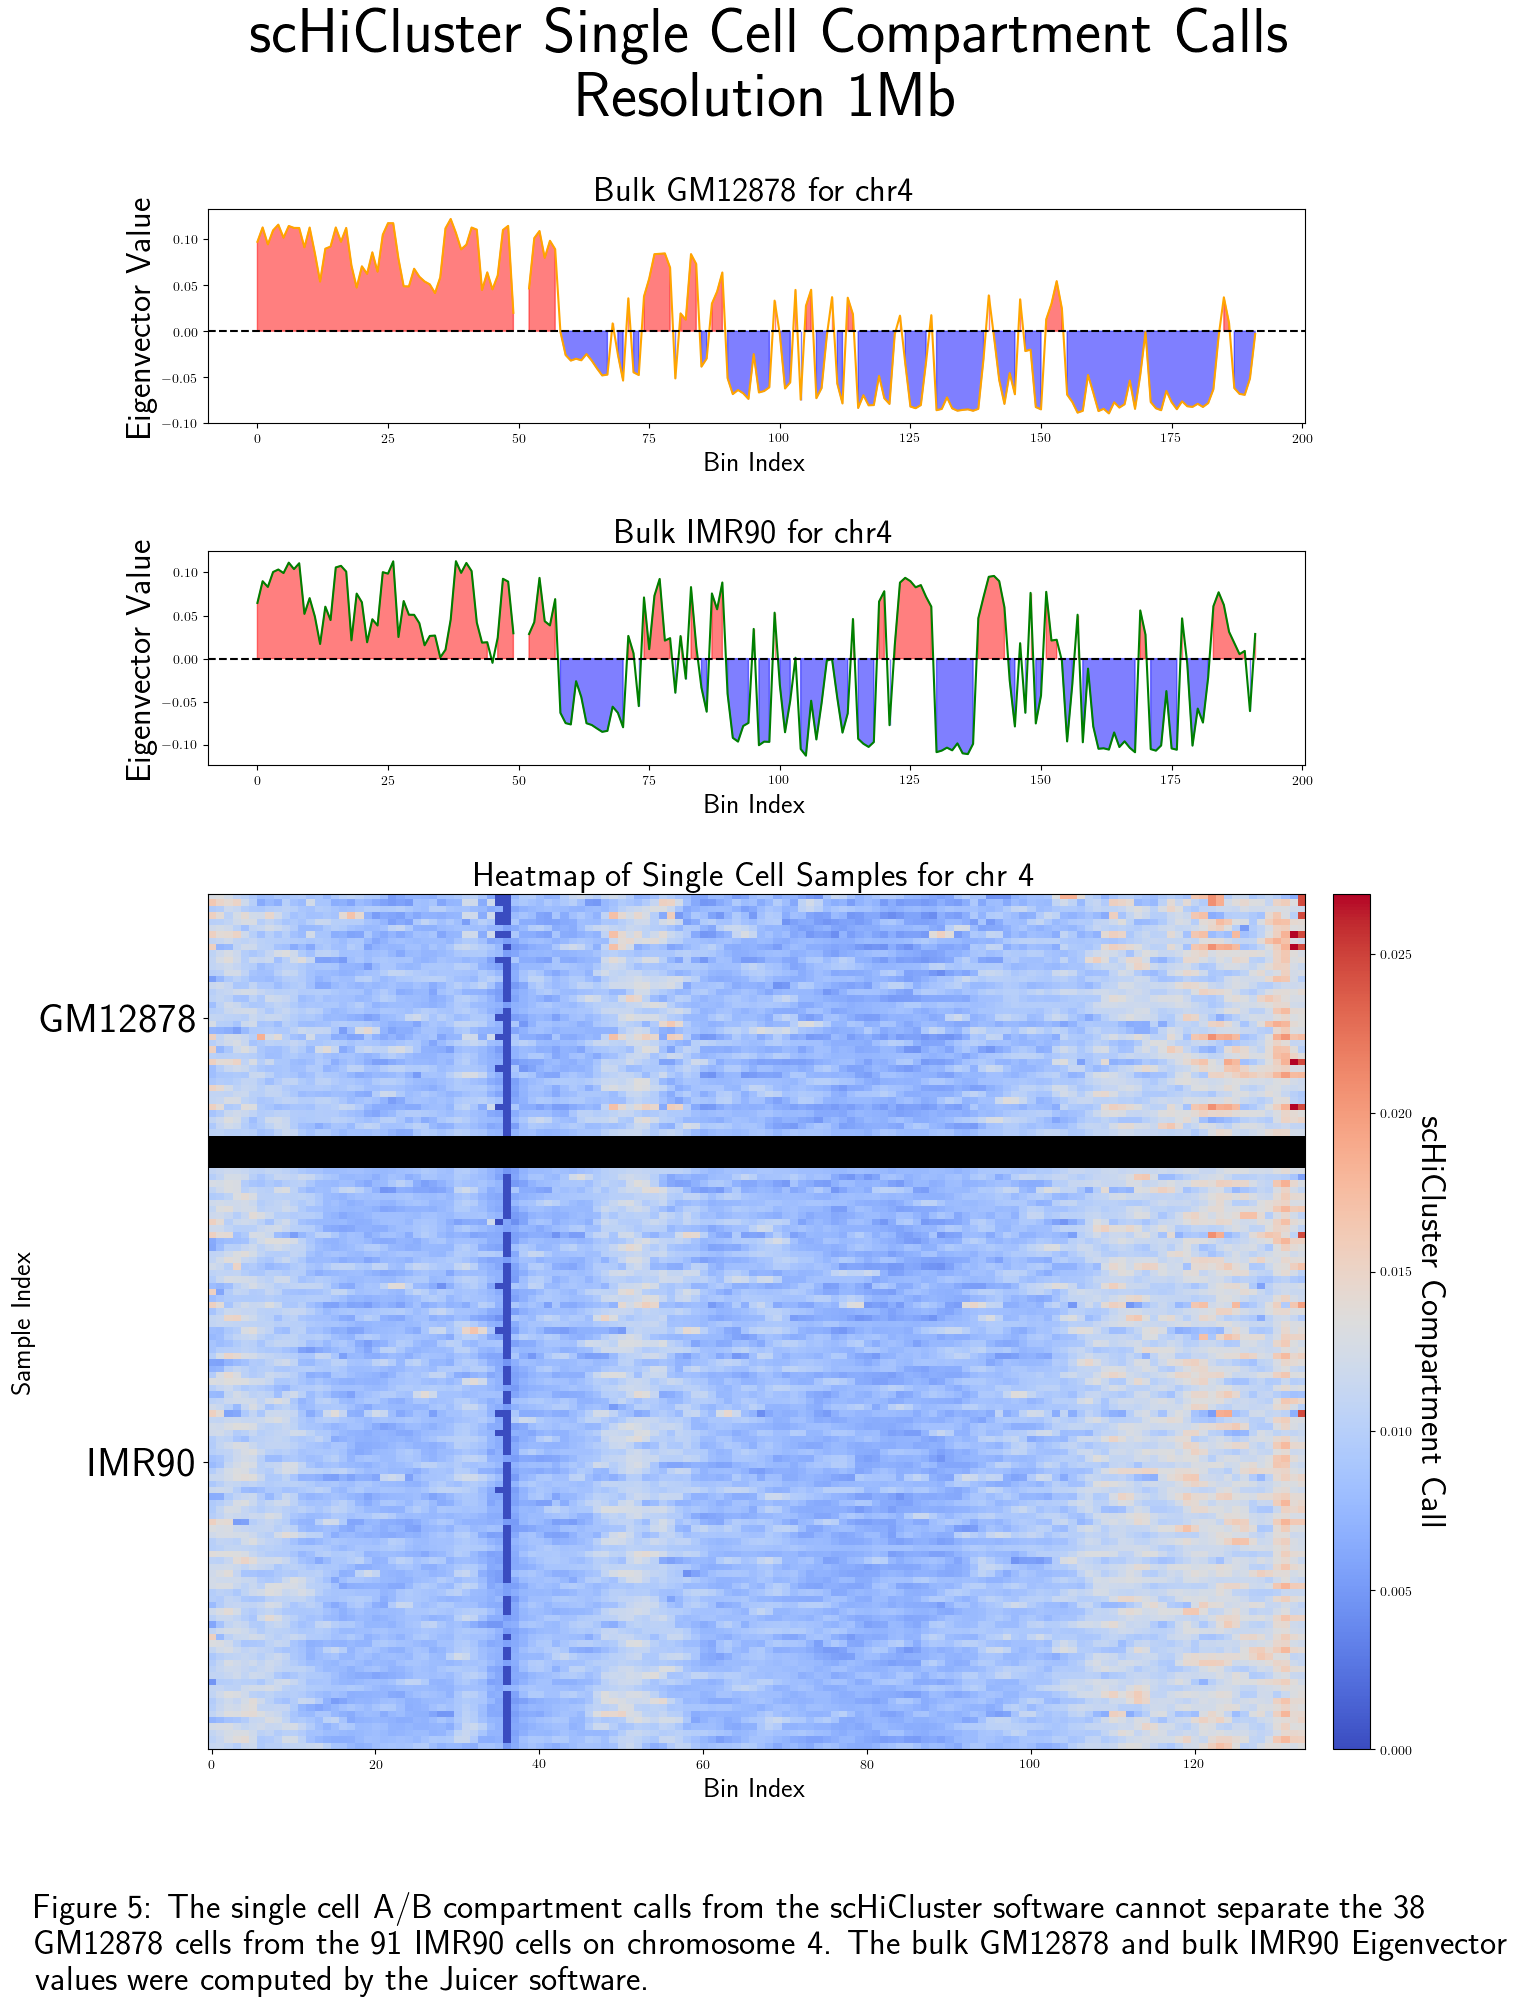

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import textwrap
import os

# Assuming the DataFrame for chromosome 11 is in sc_dataframes_list[11]
chr = 4
sc_dataframe = sc_dataframes_list[11]  # This assumes your sc_dataframes_list contains the desired DataFrame

# Define the bulk eigenvectors for chromosome 11
bulk_eigenvector_gm12878 = original_bulk_data[f'res{resolution}_ch{chr}_oe_GM12878_{normalization}_eigenvector']['eigenvalue'].values
bulk_eigenvector_imr90 = original_bulk_data[f'res{resolution}_ch{chr}_oe_IMR90_{normalization}_eigenvector']['eigenvalue'].values

plt.rcParams['text.usetex'] = True

def plot_eigenvectors_with_heatmap(bulk_eigenvector1, bulk_eigenvector2, sc_dataframe, title1, title2, title, chr, save_path=None, separation_rows=5):
    fig = plt.figure(figsize=(15, 20))  # Adjusted the figure size for better proportions
    gs = gridspec.GridSpec(nrows=3, ncols=2, figure=fig, width_ratios=[30, 1], height_ratios=[1, 1, 4], hspace=0.3, wspace=0.05)

    ax_bulk1 = fig.add_subplot(gs[0, 0])
    ax_bulk1.plot(bulk_eigenvector1, color='orange')
    ax_bulk1.axhline(0, color='black', linestyle='--')  # Add y = 0 line
    ax_bulk1.fill_between(range(len(bulk_eigenvector1)), bulk_eigenvector1, where=(bulk_eigenvector1 >= 0), color='red', alpha=0.5)
    ax_bulk1.fill_between(range(len(bulk_eigenvector1)), bulk_eigenvector1, where=(bulk_eigenvector1 < 0), color='blue', alpha=0.5)
    ax_bulk1.set_title(title1, fontsize=25)
    ax_bulk1.set_xlabel("Bin Index", fontsize=20)
    ax_bulk1.set_ylabel("Eigenvector Value", fontsize=25)

    ax_bulk2 = fig.add_subplot(gs[1, 0])
    ax_bulk2.plot(bulk_eigenvector2, color='green')
    ax_bulk2.axhline(0, color='black', linestyle='--')  # Add y = 0 line
    ax_bulk2.fill_between(range(len(bulk_eigenvector2)), bulk_eigenvector2, where=(bulk_eigenvector2 >= 0), color='red', alpha=0.5)
    ax_bulk2.fill_between(range(len(bulk_eigenvector2)), bulk_eigenvector2, where=(bulk_eigenvector2 < 0), color='blue', alpha=0.5)
    ax_bulk2.set_title(title2, fontsize=25)
    ax_bulk2.set_xlabel("Bin Index", fontsize=20)
    ax_bulk2.set_ylabel("Eigenvector Value", fontsize=25)

    gm12878_data = np.stack(sc_dataframe[sc_dataframe['Label'] == 'gm12878']['Bin_Values'].apply(lambda x: np.array(x)).tolist())
    imr90_data = np.stack(sc_dataframe[sc_dataframe['Label'] == 'imr90']['Bin_Values'].apply(lambda x: np.array(x)).tolist())
    
    empty_rows = np.full((separation_rows, gm12878_data.shape[1]), np.nan)
    sc_data_array = np.vstack([gm12878_data, empty_rows, imr90_data])

    # Create a colormap that does not include white for NaN values
    cmap = plt.cm.coolwarm
    cmap.set_bad(color='black')  # Set NaN color to black

    ax_sc = fig.add_subplot(gs[2, 0])
    im = ax_sc.imshow(sc_data_array, aspect='auto', cmap=cmap, interpolation='nearest')  # Use the adjusted colormap
    ax_sc.set_title(f"Heatmap of Single Cell Samples for chr {chr}", fontsize=25)  # Slightly larger font for the title
    ax_sc.set_xlabel("Bin Index", fontsize=20)
    ax_sc.set_ylabel("Sample Index", fontsize=20)

    num_gm12878 = len(gm12878_data)
    num_imr90 = len(imr90_data)
    
    ax_sc.set_yticks([num_gm12878 / 2, num_gm12878 + separation_rows + num_imr90 / 2])
    ax_sc.set_yticklabels(['GM12878', 'IMR90'], fontsize=30)

    ax_cbar = fig.add_subplot(gs[2, 1])
    fig.colorbar(im, cax=ax_cbar)
    ax_cbar.set_ylabel('scHiCluster Compartment Call', rotation=270, labelpad=25, fontsize=25)

    plt.suptitle(title, fontsize=45, fontweight='bold')  

    # Construct the caption
    caption = (f"Figure 5: The single cell A/B compartment calls from the scHiCluster software cannot separate the " 
               f"{num_gm12878} GM12878 cells from the {num_imr90} IMR90 cells on chromosome {chr}. "
               f"The bulk GM12878 and bulk IMR90 Eigenvector values were computed by the Juicer software. "
              )

    # Use textwrap to wrap the caption text within a specific width
    wrapped_caption = textwrap.fill(caption, width=100)

    # Add the caption at the bottom with automatic wrapping
    plt.figtext(0.01, -0.01, wrapped_caption, wrap=True, horizontalalignment='left', fontsize=25)

    if save_path:
        # Ensure the save directory exists
        save_directory = os.path.dirname(save_path)
        if not os.path.exists(save_directory):
            os.makedirs(save_directory)
        
        plt.savefig(save_path, bbox_inches='tight')

    plt.show()

# Example invocation with the genome-wide correlation value and chromosome number
plot_eigenvectors_with_heatmap(
    bulk_eigenvector_gm12878,
    bulk_eigenvector_imr90,
    sc_dataframe,
    f"Bulk GM12878 for chr{chr}",
    f"Bulk IMR90 for chr{chr}",
    f"scHiCluster Single Cell Compartment Calls\n Resolution {resolution_label}",
    chr=chr,  # Use the chromosome number variable
    save_path=f"../../files/AB_compartment_heatmap_ch{chr}_example_scHIcluster.png"
)


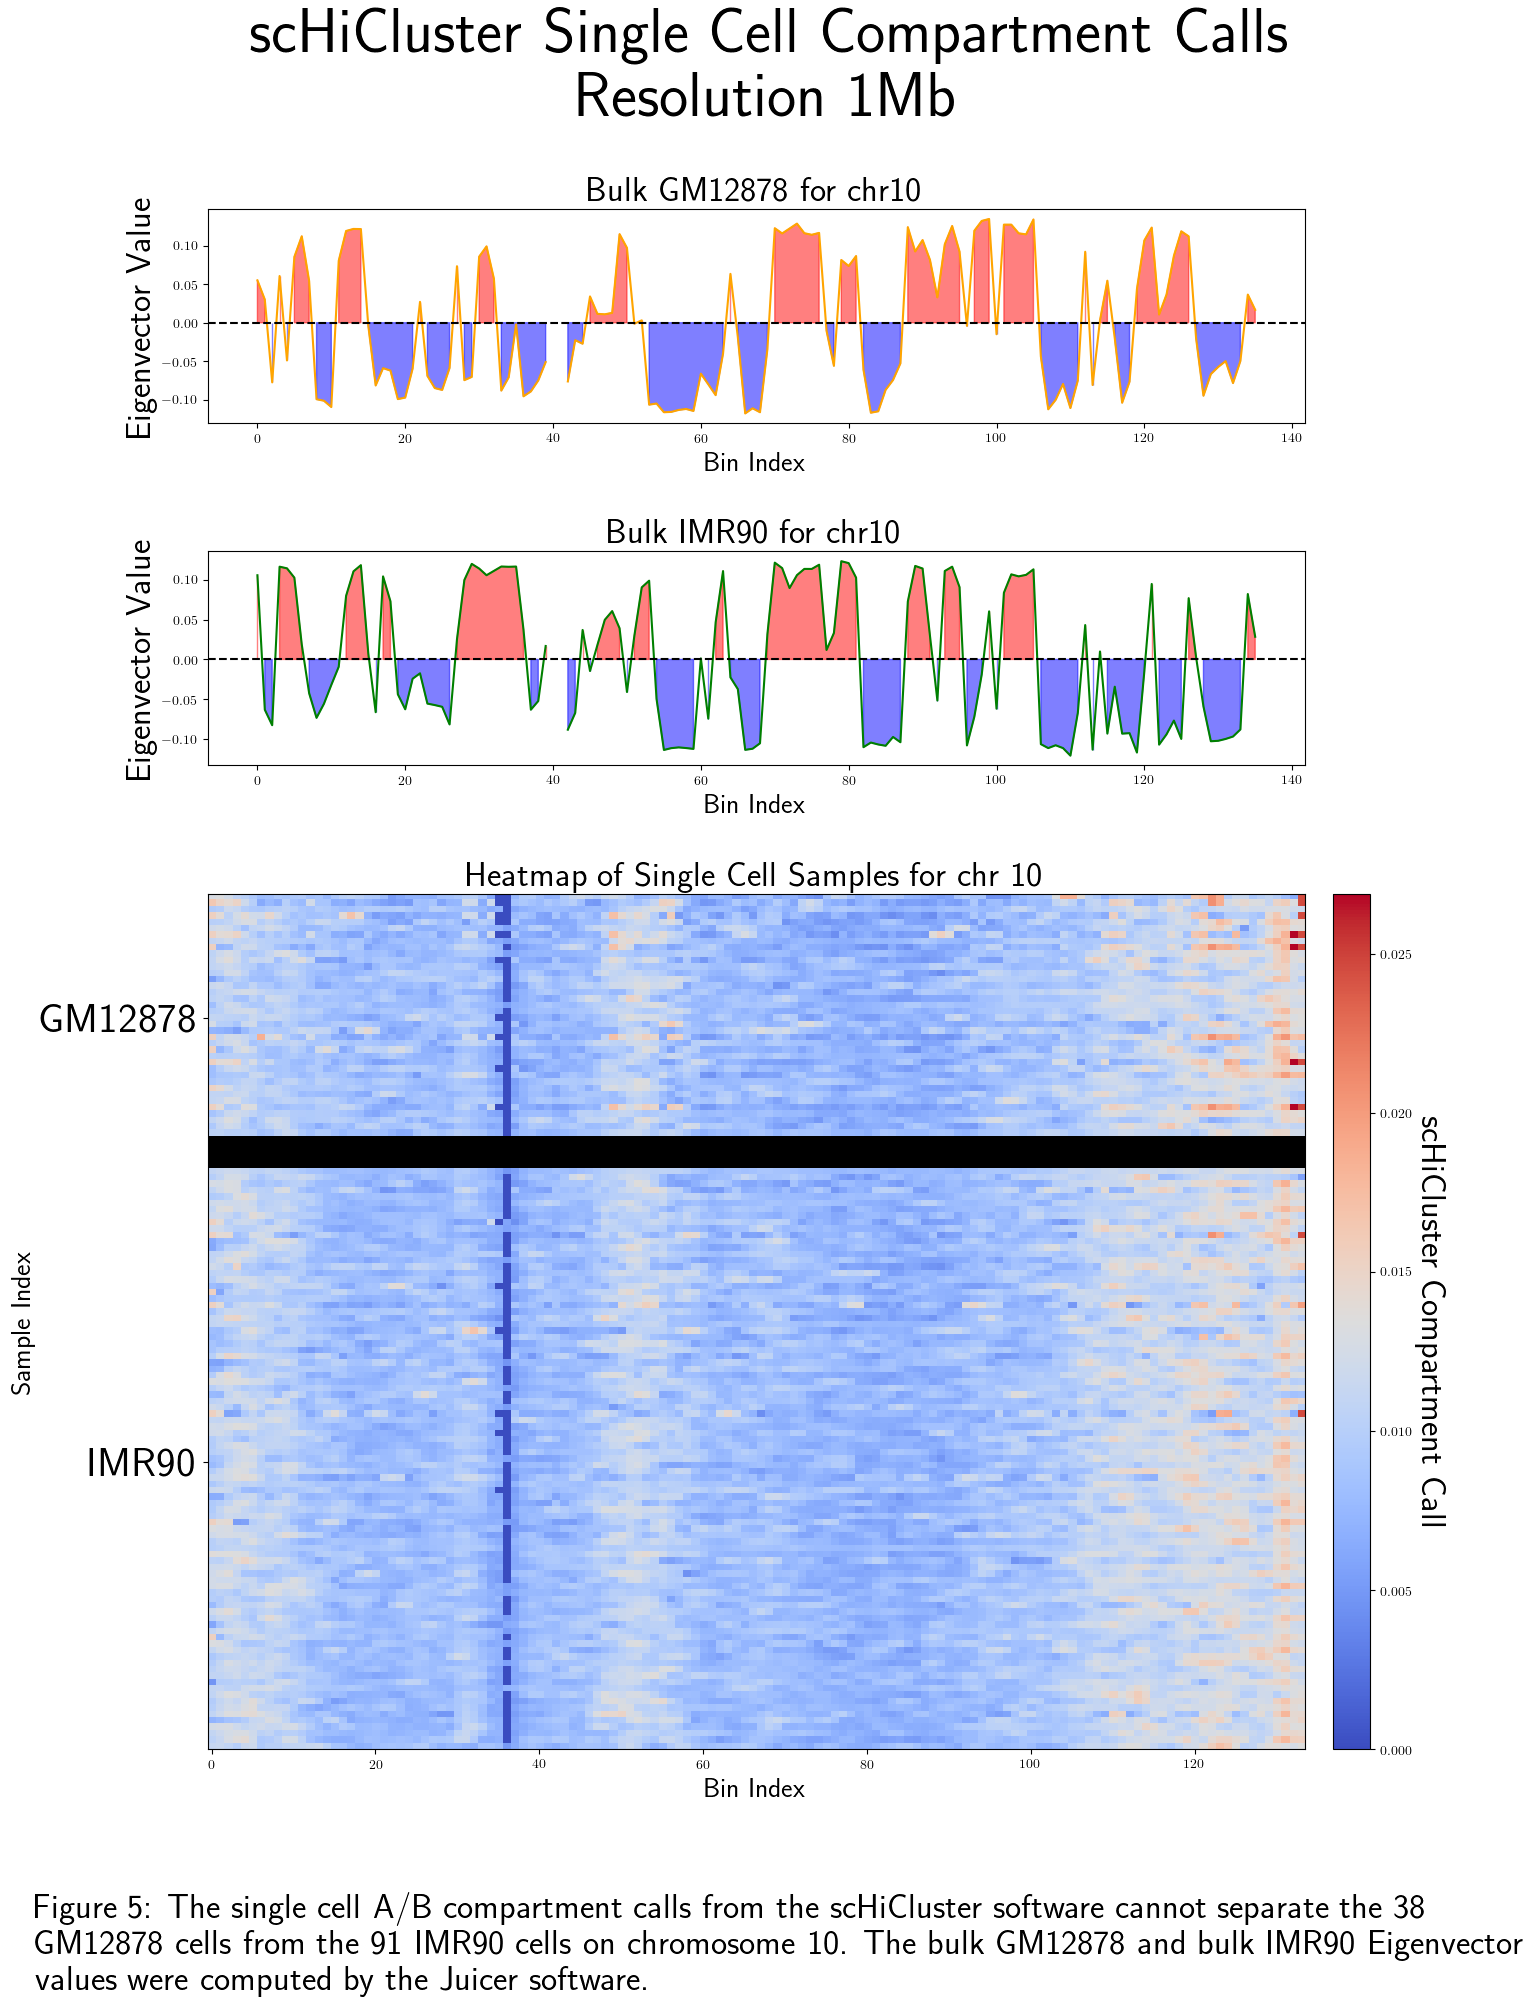

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import textwrap
import os

# Assuming the DataFrame for chromosome 11 is in sc_dataframes_list[11]
chr = 10
sc_dataframe = sc_dataframes_list[11]  # This assumes your sc_dataframes_list contains the desired DataFrame

# Define the bulk eigenvectors for chromosome 11
bulk_eigenvector_gm12878 = original_bulk_data[f'res{resolution}_ch{chr}_oe_GM12878_{normalization}_eigenvector']['eigenvalue'].values
bulk_eigenvector_imr90 = original_bulk_data[f'res{resolution}_ch{chr}_oe_IMR90_{normalization}_eigenvector']['eigenvalue'].values

plt.rcParams['text.usetex'] = True

def plot_eigenvectors_with_heatmap(bulk_eigenvector1, bulk_eigenvector2, sc_dataframe, title1, title2, title, chr, save_path=None, separation_rows=5):
    fig = plt.figure(figsize=(15, 20))  # Adjusted the figure size for better proportions
    gs = gridspec.GridSpec(nrows=3, ncols=2, figure=fig, width_ratios=[30, 1], height_ratios=[1, 1, 4], hspace=0.3, wspace=0.05)

    ax_bulk1 = fig.add_subplot(gs[0, 0])
    ax_bulk1.plot(bulk_eigenvector1, color='orange')
    ax_bulk1.axhline(0, color='black', linestyle='--')  # Add y = 0 line
    ax_bulk1.fill_between(range(len(bulk_eigenvector1)), bulk_eigenvector1, where=(bulk_eigenvector1 >= 0), color='red', alpha=0.5)
    ax_bulk1.fill_between(range(len(bulk_eigenvector1)), bulk_eigenvector1, where=(bulk_eigenvector1 < 0), color='blue', alpha=0.5)
    ax_bulk1.set_title(title1, fontsize=25)
    ax_bulk1.set_xlabel("Bin Index", fontsize=20)
    ax_bulk1.set_ylabel("Eigenvector Value", fontsize=25)

    ax_bulk2 = fig.add_subplot(gs[1, 0])
    ax_bulk2.plot(bulk_eigenvector2, color='green')
    ax_bulk2.axhline(0, color='black', linestyle='--')  # Add y = 0 line
    ax_bulk2.fill_between(range(len(bulk_eigenvector2)), bulk_eigenvector2, where=(bulk_eigenvector2 >= 0), color='red', alpha=0.5)
    ax_bulk2.fill_between(range(len(bulk_eigenvector2)), bulk_eigenvector2, where=(bulk_eigenvector2 < 0), color='blue', alpha=0.5)
    ax_bulk2.set_title(title2, fontsize=25)
    ax_bulk2.set_xlabel("Bin Index", fontsize=20)
    ax_bulk2.set_ylabel("Eigenvector Value", fontsize=25)

    gm12878_data = np.stack(sc_dataframe[sc_dataframe['Label'] == 'gm12878']['Bin_Values'].apply(lambda x: np.array(x)).tolist())
    imr90_data = np.stack(sc_dataframe[sc_dataframe['Label'] == 'imr90']['Bin_Values'].apply(lambda x: np.array(x)).tolist())
    
    empty_rows = np.full((separation_rows, gm12878_data.shape[1]), np.nan)
    sc_data_array = np.vstack([gm12878_data, empty_rows, imr90_data])

    # Create a colormap that does not include white for NaN values
    cmap = plt.cm.coolwarm
    cmap.set_bad(color='black')  # Set NaN color to black

    ax_sc = fig.add_subplot(gs[2, 0])
    im = ax_sc.imshow(sc_data_array, aspect='auto', cmap=cmap, interpolation='nearest')  # Use the adjusted colormap
    ax_sc.set_title(f"Heatmap of Single Cell Samples for chr {chr}", fontsize=25)  # Slightly larger font for the title
    ax_sc.set_xlabel("Bin Index", fontsize=20)
    ax_sc.set_ylabel("Sample Index", fontsize=20)

    num_gm12878 = len(gm12878_data)
    num_imr90 = len(imr90_data)
    
    ax_sc.set_yticks([num_gm12878 / 2, num_gm12878 + separation_rows + num_imr90 / 2])
    ax_sc.set_yticklabels(['GM12878', 'IMR90'], fontsize=30)

    ax_cbar = fig.add_subplot(gs[2, 1])
    fig.colorbar(im, cax=ax_cbar)
    ax_cbar.set_ylabel('scHiCluster Compartment Call', rotation=270, labelpad=25, fontsize=25)

    plt.suptitle(title, fontsize=45, fontweight='bold')  

    # Construct the caption
    caption = (f"Figure 5: The single cell A/B compartment calls from the scHiCluster software cannot separate the " 
               f"{num_gm12878} GM12878 cells from the {num_imr90} IMR90 cells on chromosome {chr}. "
               f"The bulk GM12878 and bulk IMR90 Eigenvector values were computed by the Juicer software. "
              )

    # Use textwrap to wrap the caption text within a specific width
    wrapped_caption = textwrap.fill(caption, width=100)

    # Add the caption at the bottom with automatic wrapping
    plt.figtext(0.01, -0.01, wrapped_caption, wrap=True, horizontalalignment='left', fontsize=25)

    if save_path:
        # Ensure the save directory exists
        save_directory = os.path.dirname(save_path)
        if not os.path.exists(save_directory):
            os.makedirs(save_directory)
        
        plt.savefig(save_path, bbox_inches='tight')

    plt.show()

# Example invocation with the genome-wide correlation value and chromosome number
plot_eigenvectors_with_heatmap(
    bulk_eigenvector_gm12878,
    bulk_eigenvector_imr90,
    sc_dataframe,
    f"Bulk GM12878 for chr{chr}",
    f"Bulk IMR90 for chr{chr}",
    f"scHiCluster Single Cell Compartment Calls\n Resolution {resolution_label}",
    chr=chr,  # Use the chromosome number variable
    save_path=f"../../files/AB_compartment_heatmap_ch{chr}_example_scHIcluster.png"
)


In [3]:
def calculate_average_correlations_from_precomputed(chromosome_results, chromosomes):
    gm12878_avg_correlations = {}
    imr90_avg_correlations = {}
    gm12878_avg_correlations_withIMR90 = {}
    imr90_avg_correlations_withGM12878 = {}
    
    for chr in chromosomes:
        # Access the specific chromosome data
        sc_dataframe = chromosome_results[f'chr{chr}']

        # Extract correlations for GM12878
        gm12878_corr_bulk = sc_dataframe[sc_dataframe['Cell Type'] == 'GM12878']['Correlation With Bulk']
        gm12878_avg_correlations[chr] = gm12878_corr_bulk.mean()
        gm12878_corr_withIMR90 = sc_dataframe[sc_dataframe['Cell Type'] == 'GM12878']['Correlation With Other Bulk']
        gm12878_avg_correlations_withIMR90[chr] = gm12878_corr_withIMR90.mean()
        
        # Extract correlations for IMR90
        imr90_corr_bulk = sc_dataframe[sc_dataframe['Cell Type'] == 'IMR90']['Correlation With Bulk']
        imr90_avg_correlations[chr] = imr90_corr_bulk.mean()
        imr90_corr_withGM12878 = sc_dataframe[sc_dataframe['Cell Type'] == 'IMR90']['Correlation With Other Bulk']
        imr90_avg_correlations_withGM12878[chr] = imr90_corr_withGM12878.mean()

    return gm12878_avg_correlations, imr90_avg_correlations, gm12878_avg_correlations_withIMR90, imr90_avg_correlations_withGM12878

chromosomes = [str(i) for i in range(1, 23)] 
gm12878_avg_corr, imr90_avg_corr, gm12878_avg_correlations_withIMR90, imr90_avg_correlations_withGM12878 = calculate_average_correlations_from_precomputed(chromosome_results, chromosomes)

# Print the results
print("Average correlations for GM12878 with bulk GM12878 and bulk IMR90 by chromosome:")
for chr in chromosomes:
    corr = gm12878_avg_corr[chr]
    corr_other = gm12878_avg_correlations_withIMR90[chr]
    print(f"Chromosome {chr}: {corr:.4f}, {corr_other:.4f}")

print("\nAverage correlations for IMR90 with bulk IMR90 and bulk GM12878 by chromosome:")
for chr in chromosomes:
    corr = imr90_avg_corr[chr]
    corr_other = imr90_avg_correlations_withGM12878[chr]
    print(f"Chromosome {chr}: {corr:.4f}, {corr_other:.4f}")


Average correlations for GM12878 with bulk GM12878 and bulk IMR90 by chromosome:
Chromosome 1: 0.1624, 0.0598
Chromosome 2: 0.1052, 0.0924
Chromosome 3: 0.0669, 0.0426
Chromosome 4: 0.2251, 0.1218
Chromosome 5: 0.1563, 0.0394
Chromosome 6: 0.1719, 0.0960
Chromosome 7: 0.0765, 0.0479
Chromosome 8: 0.0675, 0.0834
Chromosome 9: 0.2089, 0.1569
Chromosome 10: 0.0886, 0.0209
Chromosome 11: 0.1141, 0.0914
Chromosome 12: 0.1459, 0.0524
Chromosome 13: 0.2252, 0.1525
Chromosome 14: 0.2026, 0.1547
Chromosome 15: 0.2377, 0.2578
Chromosome 16: 0.2060, 0.1469
Chromosome 17: 0.1487, 0.1156
Chromosome 18: 0.1393, 0.1185
Chromosome 19: 0.1993, 0.1999
Chromosome 20: 0.2506, 0.2026
Chromosome 21: 0.3591, 0.3564
Chromosome 22: 0.2345, 0.2372

Average correlations for IMR90 with bulk IMR90 and bulk GM12878 by chromosome:
Chromosome 1: 0.1256, 0.2110
Chromosome 2: 0.1002, 0.0961
Chromosome 3: 0.1060, 0.0601
Chromosome 4: 0.1551, 0.2373
Chromosome 5: 0.0668, 0.1380
Chromosome 6: 0.1150, 0.1661
Chromosome 7: 

In [4]:
import numpy as np

def calculate_average_correlations_from_precomputed(chromosome_results, chromosomes):
    gm12878_avg_correlations = []
    imr90_avg_correlations = []
    gm12878_avg_correlations_withIMR90 = []
    imr90_avg_correlations_withGM12878 = []
    
    for chr in chromosomes:
        # Access the specific chromosome data
        sc_dataframe = chromosome_results[f'chr{chr}']

        # Extract correlations for GM12878
        gm12878_corr_bulk = sc_dataframe[sc_dataframe['Cell Type'] == 'GM12878']['Correlation With Bulk'].mean()
        gm12878_corr_withIMR90 = sc_dataframe[sc_dataframe['Cell Type'] == 'GM12878']['Correlation With Other Bulk'].mean()
        
        # Extract correlations for IMR90
        imr90_corr_bulk = sc_dataframe[sc_dataframe['Cell Type'] == 'IMR90']['Correlation With Bulk'].mean()
        imr90_corr_withGM12878 = sc_dataframe[sc_dataframe['Cell Type'] == 'IMR90']['Correlation With Other Bulk'].mean()

        # Check for -inf values and only include valid correlations
        if not np.isinf(gm12878_corr_bulk):
            gm12878_avg_correlations.append(gm12878_corr_bulk)
        if not np.isinf(gm12878_corr_withIMR90):
            gm12878_avg_correlations_withIMR90.append(gm12878_corr_withIMR90)
        if not np.isinf(imr90_corr_bulk):
            imr90_avg_correlations.append(imr90_corr_bulk)
        if not np.isinf(imr90_corr_withGM12878):
            imr90_avg_correlations_withGM12878.append(imr90_corr_withGM12878)

    # Compute overall averages across all chromosomes, ignoring -inf values
    overall_gm12878_avg_correlation = sum(gm12878_avg_correlations) / len(gm12878_avg_correlations) if gm12878_avg_correlations else np.nan
    overall_imr90_avg_correlation = sum(imr90_avg_correlations) / len(imr90_avg_correlations) if imr90_avg_correlations else np.nan
    overall_gm12878_avg_corr_withIMR90 = sum(gm12878_avg_correlations_withIMR90) / len(gm12878_avg_correlations_withIMR90) if gm12878_avg_correlations_withIMR90 else np.nan
    overall_imr90_avg_corr_withGM12878 = sum(imr90_avg_correlations_withGM12878) / len(imr90_avg_correlations_withGM12878) if imr90_avg_correlations_withGM12878 else np.nan

    return overall_gm12878_avg_correlation, overall_imr90_avg_correlation, overall_gm12878_avg_corr_withIMR90, overall_imr90_avg_corr_withGM12878

chromosomes = [str(i) for i in range(1, 23)] 
overall_gm12878_avg_corr, overall_imr90_avg_corr, overall_gm12878_avg_corr_withIMR90, overall_imr90_avg_corr_withGM12878 = calculate_average_correlations_from_precomputed(chromosome_results, chromosomes)

# Print the overall results
print("Overall average correlations (ignoring -inf):")
print(f"GM12878 with bulk GM12878: {overall_gm12878_avg_corr:.4f}")
print(f"GM12878 with bulk IMR90: {overall_gm12878_avg_corr_withIMR90:.4f}")
print(f"IMR90 with bulk IMR90: {overall_imr90_avg_corr:.4f}")
print(f"IMR90 with bulk GM12878: {overall_imr90_avg_corr_withGM12878:.4f}")


Overall average correlations (ignoring -inf):
GM12878 with bulk GM12878: 0.1724
GM12878 with bulk IMR90: 0.1294
IMR90 with bulk IMR90: 0.1633
IMR90 with bulk GM12878: 0.1802


{}

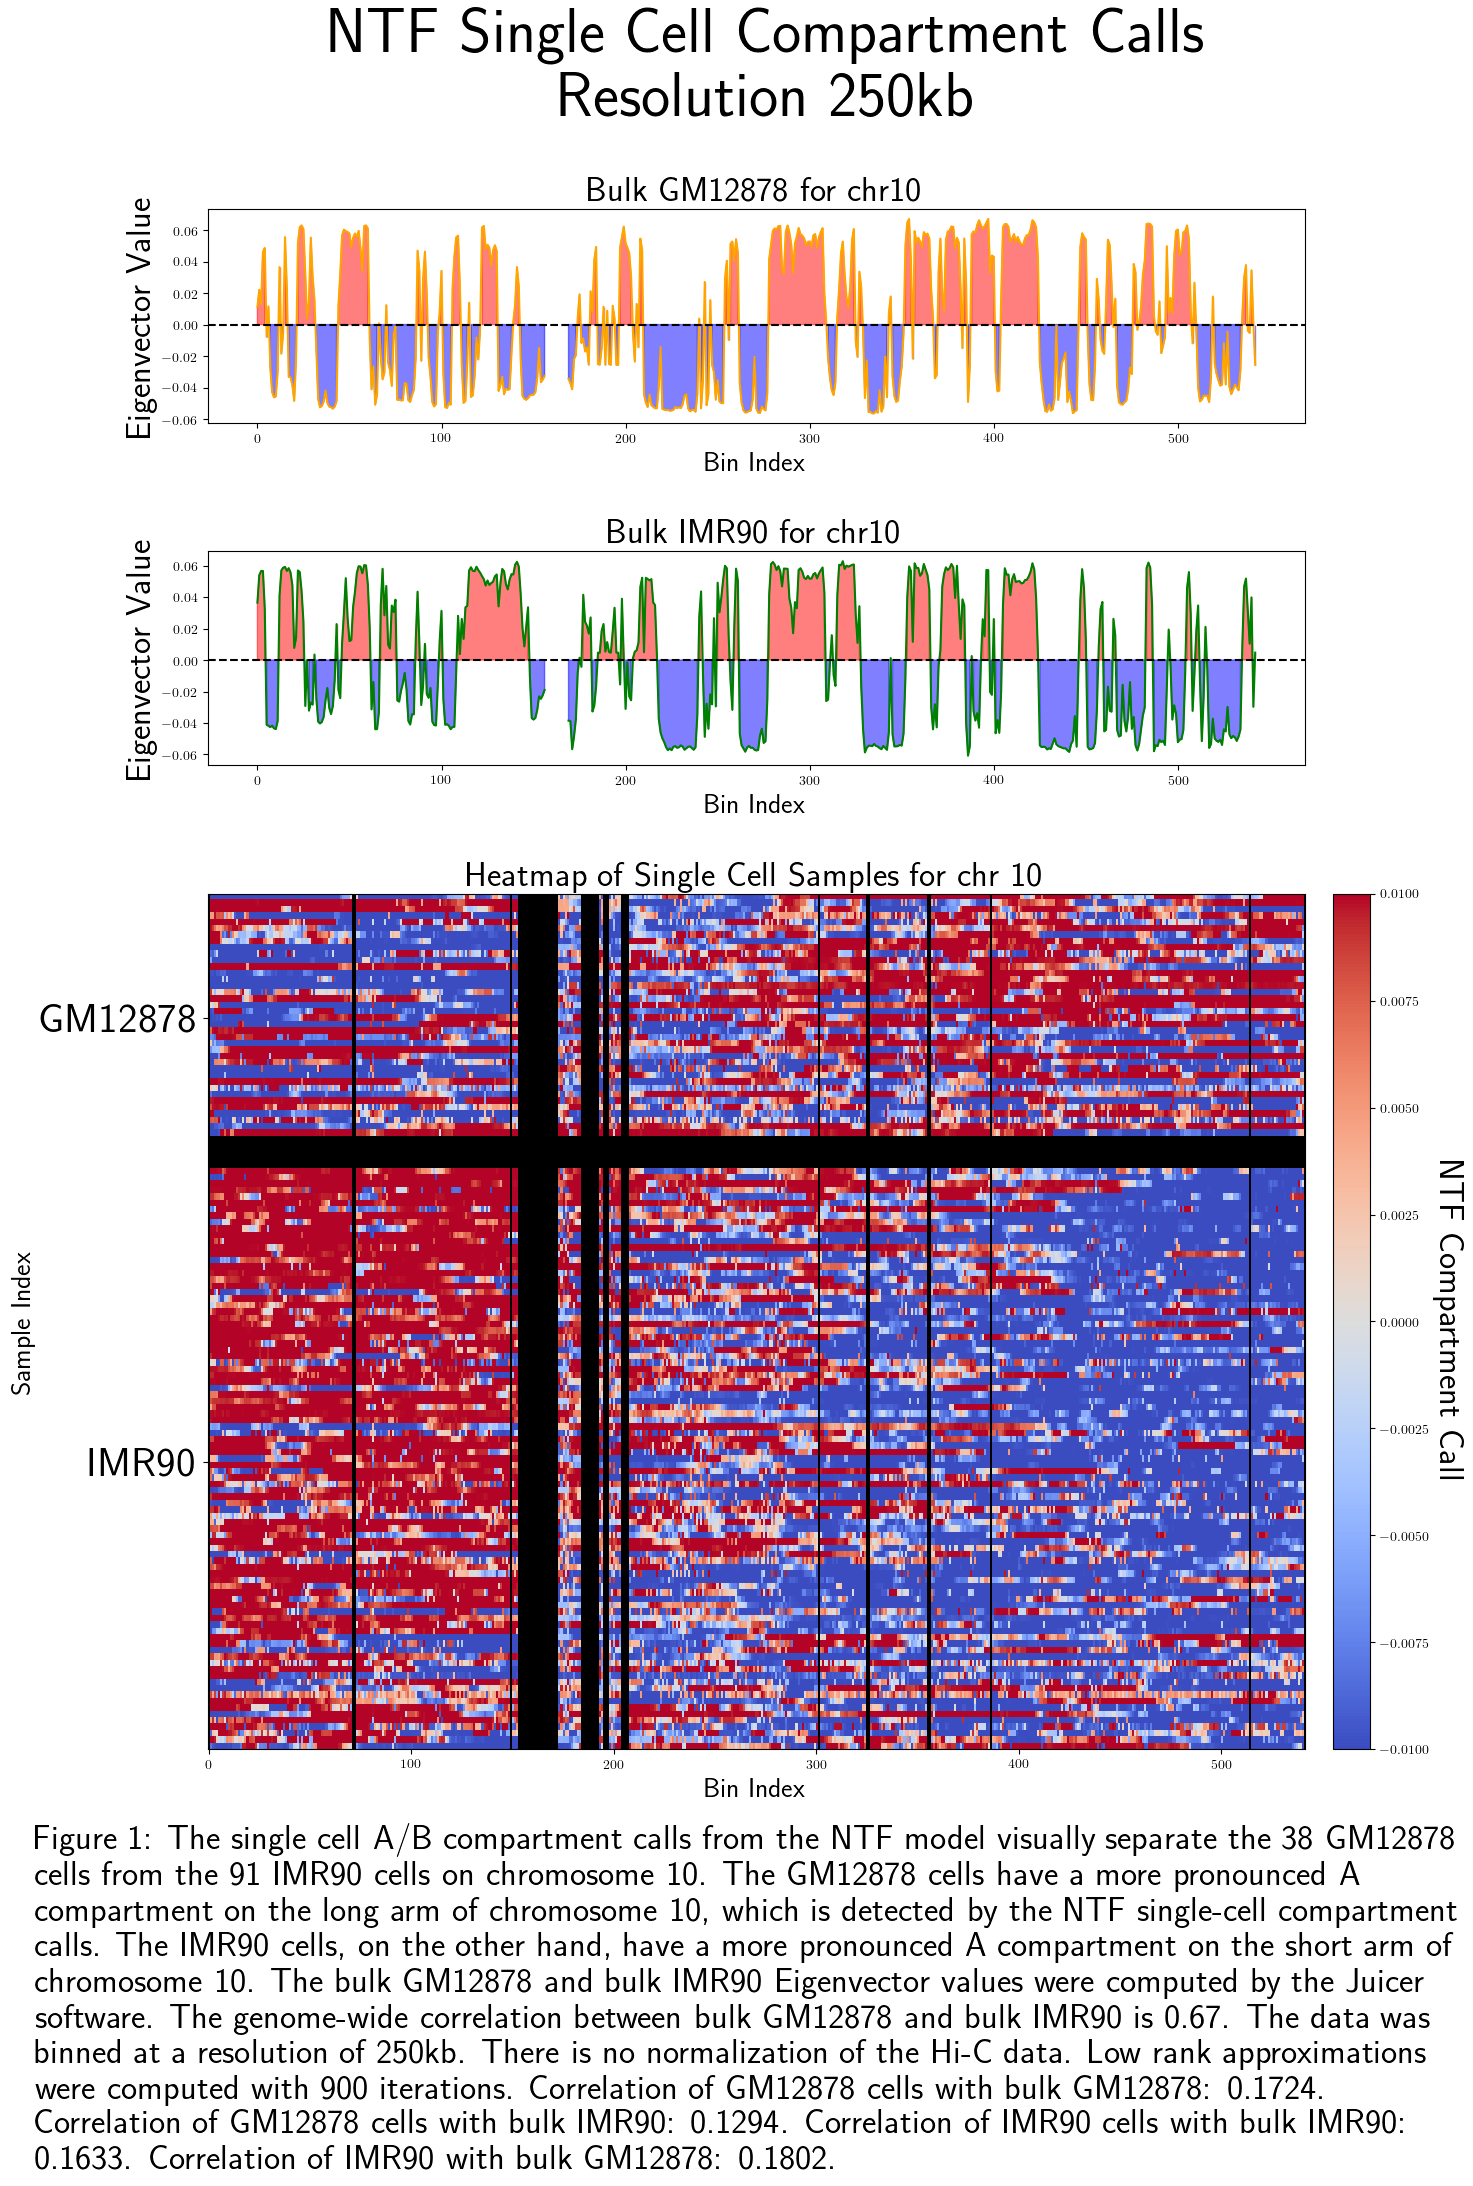

In [5]:
chr = 10
sc_dataframe = chromosome_results[f'chr{chr}']

# Define the bulk eigenvectors
bulk_eigenvector_gm12878 = original_bulk_data[f'res{resolution}_ch{chr}_oe_GM12878_{normalization}_eigenvector']['eigenvalue'].values
bulk_eigenvector_imr90 = original_bulk_data[f'res{resolution}_ch{chr}_oe_IMR90_{normalization}_eigenvector']['eigenvalue'].values

# Sort and prepare the dataframe
sc_dataframe['Cell Type Sort'] = sc_dataframe['Cell Type'].map({'GM12878': 0, 'IMR90': 1})
sc_dataframe = sc_dataframe.sort_values(by=['Cell Type Sort', 'Correlation With Bulk'], ascending=[True, False])
sc_dataframe.drop('Cell Type Sort', axis=1, inplace=True)

plt.rcParams['text.usetex'] = True

def plot_eigenvectors_with_heatmap(bulk_eigenvector1, bulk_eigenvector2, sc_dataframe, title1, title2, title, chr, save_path=None, separation_rows=5):
    fig = plt.figure(figsize=(15, 20))  # Adjusted the figure size for better proportions
    gs = gridspec.GridSpec(nrows=3, ncols=2, figure=fig, width_ratios=[30, 1], height_ratios=[1, 1, 4], hspace=0.3, wspace=0.05)

    ax_bulk1 = fig.add_subplot(gs[0, 0])
    ax_bulk1.plot(bulk_eigenvector1, color='orange')
    ax_bulk1.axhline(0, color='black', linestyle='--')  # Add y = 0 line
    ax_bulk1.fill_between(range(len(bulk_eigenvector1)), bulk_eigenvector1, where=(bulk_eigenvector1 >= 0), color='red', alpha=0.5)
    ax_bulk1.fill_between(range(len(bulk_eigenvector1)), bulk_eigenvector1, where=(bulk_eigenvector1 < 0), color='blue', alpha=0.5)
    ax_bulk1.set_title(title1, fontsize=25)
    ax_bulk1.set_xlabel("Bin Index", fontsize=20)
    ax_bulk1.set_ylabel("Eigenvector Value", fontsize=25)

    ax_bulk2 = fig.add_subplot(gs[1, 0])
    ax_bulk2.plot(bulk_eigenvector2, color='green')
    ax_bulk2.axhline(0, color='black', linestyle='--')  # Add y = 0 line
    ax_bulk2.fill_between(range(len(bulk_eigenvector2)), bulk_eigenvector2, where=(bulk_eigenvector2 >= 0), color='red', alpha=0.5)
    ax_bulk2.fill_between(range(len(bulk_eigenvector2)), bulk_eigenvector2, where=(bulk_eigenvector2 < 0), color='blue', alpha=0.5)
    ax_bulk2.set_title(title2, fontsize=25)
    ax_bulk2.set_xlabel("Bin Index", fontsize=20)
    ax_bulk2.set_ylabel("Eigenvector Value", fontsize=25)

    gm12878_data = np.stack(sc_dataframe[sc_dataframe['Cell Type'] == 'GM12878']['A/B Compartment'].apply(lambda x: np.array(x)).tolist())
    imr90_data = np.stack(sc_dataframe[sc_dataframe['Cell Type'] == 'IMR90']['A/B Compartment'].apply(lambda x: np.array(x)).tolist())
    
    empty_rows = np.full((separation_rows, gm12878_data.shape[1]), np.nan)
    sc_data_array = np.vstack([gm12878_data, empty_rows, imr90_data])

    # Create a colormap that does not include white for NaN values
    cmap = plt.cm.coolwarm
    cmap.set_bad(color='black')  # Set NaN color to black

    ax_sc = fig.add_subplot(gs[2, 0])
    im = ax_sc.imshow(sc_data_array, aspect='auto', cmap=cmap, interpolation='nearest')  # Use the adjusted colormap
    ax_sc.set_title(f"Heatmap of Single Cell Samples for chr {chr}", fontsize=25)  # Slightly larger font for the title
    ax_sc.set_xlabel("Bin Index", fontsize=20)
    ax_sc.set_ylabel("Sample Index", fontsize=20)

    num_gm12878 = len(gm12878_data)
    num_imr90 = len(imr90_data)
    
    ax_sc.set_yticks([num_gm12878 / 2, num_gm12878 + separation_rows + num_imr90 / 2])
    ax_sc.set_yticklabels(['GM12878', 'IMR90'], fontsize=30)

    ax_cbar = fig.add_subplot(gs[2, 1])
    fig.colorbar(im, cax=ax_cbar)
    ax_cbar.set_ylabel('NTF Compartment Call', rotation=270, labelpad=25, fontsize=25)

    plt.suptitle(title, fontsize=45, fontweight='bold')  

    # Construct the caption
    caption = (f"Figure 1: The single cell A/B compartment calls from the NTF model visually separate the " 
               f"{num_gm12878} GM12878 cells from the {num_imr90} IMR90 cells on chromosome {chr}. "
               f"The GM12878 cells have a more pronounced A compartment on the long arm of chromosome {chr}, which is detected by the "
               f"NTF single-cell compartment calls. The IMR90 cells, on the other hand, have a more pronounced A compartment on the "
               f"short arm of chromosome {chr}. "
               f"The bulk GM12878 and bulk IMR90 Eigenvector values were computed by the Juicer software. "
               f"The genome-wide correlation between bulk GM12878 and bulk IMR90 is {genome_wide_correlation:.2f}. "
               f"The data was binned at a resolution of {resolution_label}. "
               f"There is no normalization of the Hi-C data. Low rank approximations were computed with {iterations} iterations. "
               f"Correlation of GM12878 cells with bulk GM12878: {overall_gm12878_avg_corr:.4f}. "
               f"Correlation of GM12878 cells with bulk IMR90: {overall_gm12878_avg_corr_withIMR90:.4f}. "
               f"Correlation of IMR90 cells with bulk IMR90: {overall_imr90_avg_corr:.4f}. "
               f"Correlation of IMR90 with bulk GM12878: {overall_imr90_avg_corr_withGM12878:.4f}. "
              )

    # Use textwrap to wrap the caption text within a specific width
    wrapped_caption = textwrap.fill(caption, width=100)

    # Add the caption at the bottom with automatic wrapping
    plt.figtext(0.01, -0.1, wrapped_caption, wrap=True, horizontalalignment='left', fontsize=25)

    if save_path:
        # Ensure the save directory exists
        save_directory = os.path.dirname(save_path)
        if not os.path.exists(save_directory):
            os.makedirs(save_directory)
        
        plt.savefig(save_path, bbox_inches='tight')

    plt.show()

# Example invocation with the genome-wide correlation value and chromosome number
plot_eigenvectors_with_heatmap(
    bulk_eigenvector_gm12878,
    bulk_eigenvector_imr90,
    sc_dataframe,
    f"Bulk GM12878 for chr{chr}",
    f"Bulk IMR90 for chr{chr}",
    f"NTF Single Cell Compartment Calls\n Resolution {resolution_label}",
    chr=chr,  # Use the chromosome number variable
    save_path=f"../../files/AB_compartment_heatmap_ch{chr}_example_iter{iterations}.png"
)


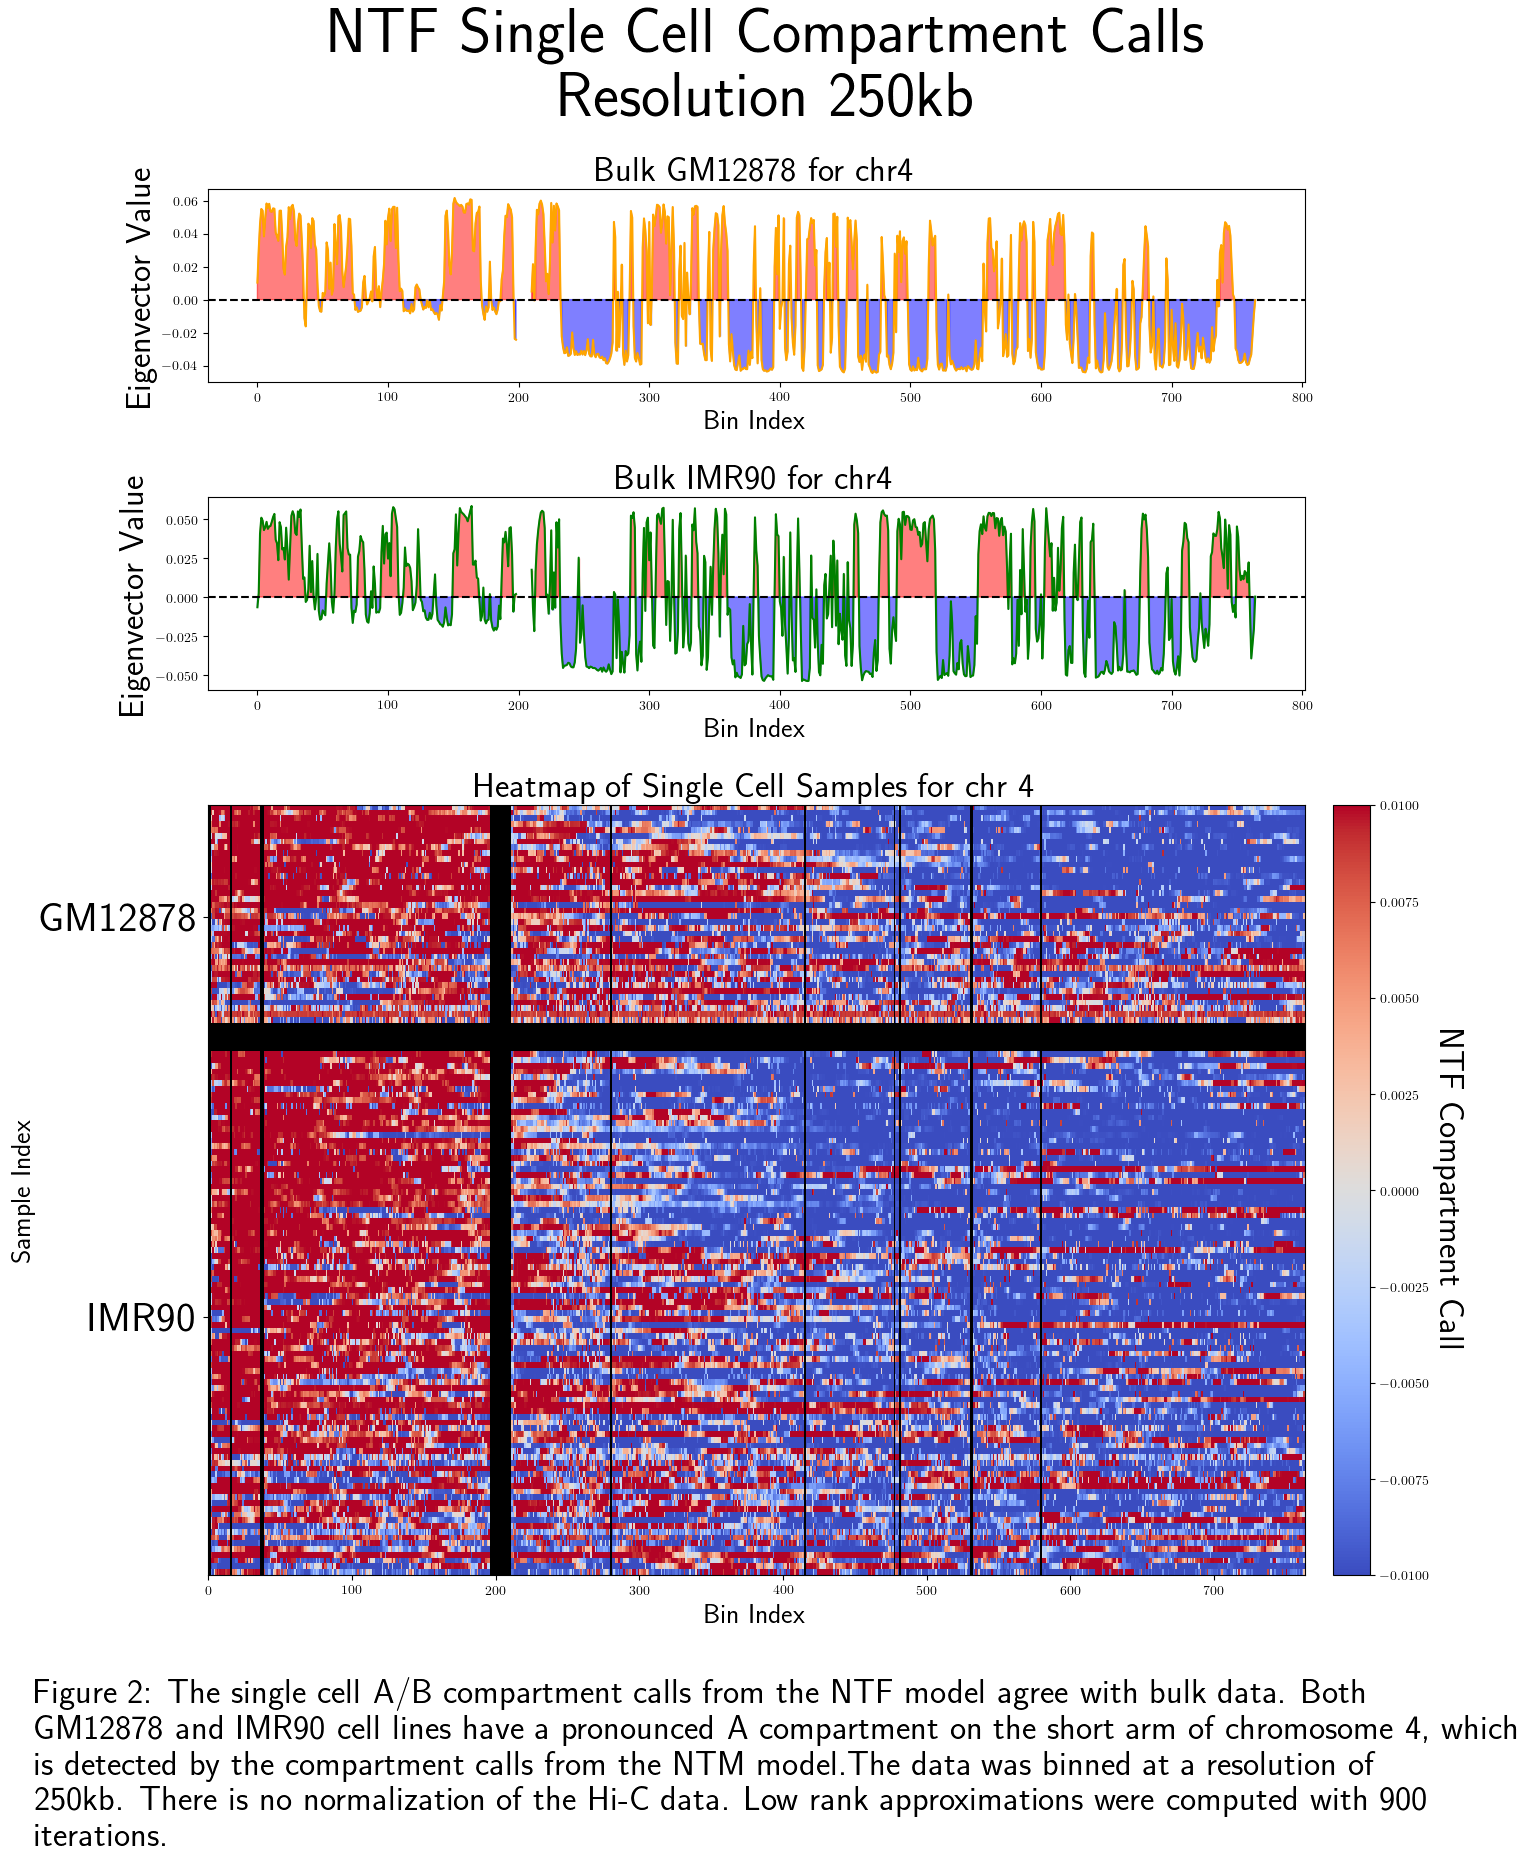

In [8]:
chr = 4
sc_dataframe = chromosome_results[f'chr{chr}']

# Define the bulk eigenvectors
bulk_eigenvector_gm12878 = original_bulk_data[f'res{resolution}_ch{chr}_oe_GM12878_{normalization}_eigenvector']['eigenvalue'].values
bulk_eigenvector_imr90 = original_bulk_data[f'res{resolution}_ch{chr}_oe_IMR90_{normalization}_eigenvector']['eigenvalue'].values

# Sort and prepare the dataframe
sc_dataframe['Cell Type Sort'] = sc_dataframe['Cell Type'].map({'GM12878': 0, 'IMR90': 1})
sc_dataframe = sc_dataframe.sort_values(by=['Cell Type Sort', 'Correlation With Bulk'], ascending=[True, False])
sc_dataframe.drop('Cell Type Sort', axis=1, inplace=True)

def plot_eigenvectors_with_heatmap(bulk_eigenvector1, bulk_eigenvector2, sc_dataframe, title1, title2, title, chr, save_path=None, separation_rows=5):
    fig = plt.figure(figsize=(15, 18))  
    gs = gridspec.GridSpec(nrows=3, ncols=2, figure=fig, width_ratios=[30, 1], height_ratios=[1, 1, 4], hspace=0.3, wspace=0.05)

    ax_bulk1 = fig.add_subplot(gs[0, 0])
    ax_bulk1.plot(bulk_eigenvector1, color='orange')
    ax_bulk1.axhline(0, color='black', linestyle='--')  # Add y = 0 line
    ax_bulk1.fill_between(range(len(bulk_eigenvector1)), bulk_eigenvector1, where=(bulk_eigenvector1 >= 0), color='red', alpha=0.5)
    ax_bulk1.fill_between(range(len(bulk_eigenvector1)), bulk_eigenvector1, where=(bulk_eigenvector1 < 0), color='blue', alpha=0.5)
    ax_bulk1.set_title(title1, fontsize=25)
    ax_bulk1.set_xlabel("Bin Index", fontsize=20)
    ax_bulk1.set_ylabel("Eigenvector Value", fontsize=25)

    ax_bulk2 = fig.add_subplot(gs[1, 0])
    ax_bulk2.plot(bulk_eigenvector2, color='green')
    ax_bulk2.axhline(0, color='black', linestyle='--')  # Add y = 0 line
    ax_bulk2.fill_between(range(len(bulk_eigenvector2)), bulk_eigenvector2, where=(bulk_eigenvector2 >= 0), color='red', alpha=0.5)
    ax_bulk2.fill_between(range(len(bulk_eigenvector2)), bulk_eigenvector2, where=(bulk_eigenvector2 < 0), color='blue', alpha=0.5)
    ax_bulk2.set_title(title2, fontsize=25)
    ax_bulk2.set_xlabel("Bin Index", fontsize=20)
    ax_bulk2.set_ylabel("Eigenvector Value", fontsize=25)

    gm12878_data = np.stack(sc_dataframe[sc_dataframe['Cell Type'] == 'GM12878']['A/B Compartment'].apply(lambda x: np.array(x)).tolist())
    imr90_data = np.stack(sc_dataframe[sc_dataframe['Cell Type'] == 'IMR90']['A/B Compartment'].apply(lambda x: np.array(x)).tolist())
    
    empty_rows = np.full((separation_rows, gm12878_data.shape[1]), np.nan)
    sc_data_array = np.vstack([gm12878_data, empty_rows, imr90_data])

    # Create a colormap that does not include white for NaN values
    cmap = plt.cm.coolwarm
    cmap.set_bad(color='black')  # Set NaN color to black

    ax_sc = fig.add_subplot(gs[2, 0])
    im = ax_sc.imshow(sc_data_array, aspect='auto', cmap=cmap, interpolation='nearest')  # Use the adjusted colormap
    ax_sc.set_title(f"Heatmap of Single Cell Samples for chr {chr}", fontsize=25)  # Slightly larger font for the title
    ax_sc.set_xlabel("Bin Index", fontsize=20)
    ax_sc.set_ylabel("Sample Index", fontsize=20)

    num_gm12878 = len(gm12878_data)
    num_imr90 = len(imr90_data)
    
    ax_sc.set_yticks([num_gm12878 / 2, num_gm12878 + separation_rows + num_imr90 / 2])
    ax_sc.set_yticklabels(['GM12878', 'IMR90'], fontsize=30)

    ax_cbar = fig.add_subplot(gs[2, 1])
    fig.colorbar(im, cax=ax_cbar)
    ax_cbar.set_ylabel('NTF Compartment Call', rotation=270, labelpad=25, fontsize=25)

    plt.suptitle(title, fontsize=45, fontweight='bold')  

    caption = (f"Figure 2: The single cell A/B compartment calls from the NTF model agree with bulk data. " 
           f"Both GM12878 and IMR90 cell lines have a pronounced A compartment on the short arm of chromosome {chr}, "
           f"which is detected by the compartment calls from the NTM model."
           f"The data was binned at a resolution of {resolution_label}. "
           f"There is no normalization of the Hi-C data. Low rank approximations were computed with {iterations} iterations. "
          )

    # Use textwrap to wrap the caption text within a specific width
    wrapped_caption = textwrap.fill(caption, width=100)

    # Add the caption at the bottom with automatic wrapping
    plt.figtext(0.01, -0.04, wrapped_caption, wrap=True, horizontalalignment='left', fontsize=25)

    if save_path:
        # Ensure the save directory exists
        save_directory = os.path.dirname(save_path)
        if not os.path.exists(save_directory):
            os.makedirs(save_directory)
        
        plt.savefig(save_path, bbox_inches='tight')

    plt.show()    
    
# Example invocation with the genome-wide correlation value and chromosome number
plot_eigenvectors_with_heatmap(
    bulk_eigenvector_gm12878,
    bulk_eigenvector_imr90,
    sc_dataframe,
    f"Bulk GM12878 for chr{chr}",
    f"Bulk IMR90 for chr{chr}",
    f"NTF Single Cell Compartment Calls\nResolution {resolution_label}",
    chr=chr,  # Use the chromosome number variable
    save_path=f"../../files/AB_compartment_heatmap_ch{chr}_example_iter{iterations}.png"
)
